In [524]:
import os
import re
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

% matplotlib inline

### Regex Setup

In [155]:
# read in all relevant files
data_path = "../logs/"
problem = "cm"
date = "07_14"

problems = {"cm":"Copy Memory Problem", "ap": "Adding Problem", "mnist":"MNIST Image Problem"}

In [163]:
# create regex to filter for just the folders we want
regex = re.compile(r'..\/logs\/{}\/.*\/07_1[6-7].*\/.*logs'.format(problem))

In [164]:
# filter just folders we want
n = []
for root, dirs, files in os.walk(os.path.join(data_path,problem), topdown=True):
    for name in dirs:
        n.append(os.path.join(root,name))
        
n = list(filter(regex.search,n))

### Helper Functions

In [245]:
def baseline_cm(timesteps):
    return 10*np.log(8) / timesteps

In [130]:
def parse_name(name):
    name = name[name.find(problem) + len(problem) + 1:]
    
    name = name[:name.find("/logs")]
    
    return name.replace("/","_")

In [397]:
# parse folder into data frame
def parse_folder(name, full_loss=False, nsteps = 781, **kwargs):
    # creates data frame (dictionary?) with a variety of attributes
    loss = np.genfromtxt(os.path.join(name,"losses.txt"), 
                  delimiter="\n",names=["loss"], autostrip=True)

    loss = [i[0] for i in loss]
    
    # if loss is less than number of steps, padd
    if len(loss) < nsteps:
        loss.extend((nsteps-len(loss))*[np.nan])
    
    # read in all other info
    with open(os.path.join(name,"info.txt")) as file:
        data = json.load(file)
    
    # get full loss patterns
    if full_loss:
        data["loss"] = loss
    
    # get average of five lowest values
    data["mean_loss"] = np.mean(np.sort(loss)[:5])
    data["num_steps"] = len(loss)
    
    return data, parse_name(name)

In [411]:
def parse_all(regex, full_loss=False, average=True, data_path = "../logs/", problem = "cm", nsteps = 781, **kwargs):
    # filter just folders we want
    n = []
    for root, dirs, files in os.walk(os.path.join(data_path,problem), topdown=True):
        for name in dirs:
            n.append(os.path.join(root,name))

    n = list(filter(regex.search,n))
    # get results for each folder
    results = {}
    for name in n:
        data, trial_name = parse_folder(name, full_loss, nsteps, **kwargs)
        results[trial_name] = data
        
    # return dataframe of full loss lists
    r = pd.DataFrame.from_dict(results).transpose()
    for column in ["mean_loss", "trainable_params","training_time"]:
        r[column] = r[column].astype(float)
    for column in ["optimizer","problem", "samples","timesteps","cell_type","batch_size"]:
        r[column] = r[column].astype('category')
    
    if full_loss:
        if average:
            return average_runs(r)
        else:
            return r
    # if we want the average but not full loss, return a pandas dataframe
    elif not full_loss:
#         r = pd.DataFrame.from_dict(results).transpose()
        # coerce numeric columnsinto the correct data format
        for column in ["mean_loss", "trainable_params","training_time"]:
            r[column] = r[column].astype(float)
        # if we want to, just return the average
        if average:
            return r.groupby("name").mean()
        # otherwise return the full dataframe
        else:
            return r

In [575]:
def average_runs(l):
    """
    Finds average loss values across all runs with same name. 
    TODO: ensure same hyperparameters etc.
    
    keep as dataframe
    
    l:data frame
    """

    if isinstance(l,dict):
        l = pd.DataFrame.from_dict(l).transpose()
        
    # keep extra information
    out_frame = l.groupby(["name","optimizer","problem", "samples",\
                          "timesteps","cell_type","batch_size"], \
                          as_index=True).mean()
    out_frame = out_frame.reset_index().set_index("name")

    # initialize list of list of losses
    loss_mean=[]
    # fill losses with averages
    for name in list(out_frame.index):
        # find ones of new description
        loss_array = np.array(list(l[l["name"]==name]["loss"]))
        loss_mean.append(np.nanmean(loss_array, axis=0))
    
    # append
    out_frame["loss"] = loss_mean
    out_frame["name"] = list(out_frame.index)
   
    return out_frame 

## Data Processing

In [576]:
mean_results = parse_all(regex, True, True)
all_results = parse_all(regex, True, False)

In [700]:
mean_results

,optimizer,problem,samples,timesteps,cell_type,batch_size,mean_loss,trainable_params,training_time,loss,name
name,,,,,,,,,,,
cm_d1,Adam,cm,100000,120,flexi_cell,128,0.068677,3082.0,2034.103756,"[3.6983675161997476, 3.462242603302002, 3.2557...",cm_d1
cm_d1fr1pd2i,Adam,cm,100000,120,flexi_cell,128,0.067468,3466.0,3738.451418,"[3.28562194108963, 2.951547384262085, 2.662931...",cm_d1fr1pd2i
cm_d1fr1pd2ir2d3,Adam,cm,100000,120,flexi_cell,128,0.068065,3850.0,4275.013187,"[3.8419175148010254, 3.3952982425689697, 3.041...",cm_d1fr1pd2ir2d3
cm_fd2i,Adam,cm,100000,120,flexi_cell,128,0.074217,3082.0,2980.079767,"[4.130217472712199, 3.7675286134084067, 3.4513...",cm_fd2i
cm_fr1d2i,Adam,cm,100000,120,flexi_cell,128,0.073406,3338.0,3282.215906,"[3.756809631983439, 3.4346863428751626, 3.1569...",cm_fr1d2i
cm_r1,Adam,cm,100000,120,flexi_cell,128,0.451276,3210.0,2390.553572,"[5.06519349416097, 2.8393641908963523, 1.31455...",cm_r1
cm_r2d3,Adam,cm,100000,120,flexi_cell,128,0.062339,3338.0,2843.538904,"[3.680895686149597, 3.4427000880241394, 3.2383...",cm_r2d3


## Visualize Results

#### Preferences

In [701]:
color_labels = mean_results['name'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Dark2_r", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

pt_size = 50
window = 10

figwidth = 8

#### Complexity/Training Loss Tradeoff

<Figure size 432x288 with 0 Axes>

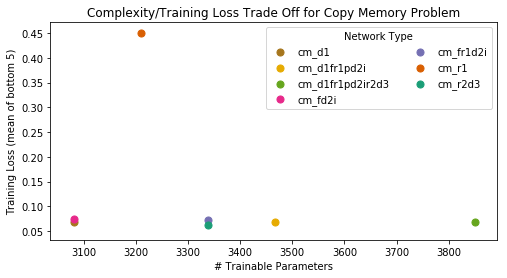

In [702]:
plt.clf()
fig = plt.figure(figsize=(figwidth,0.5*figwidth))

# for key, val in results.items():
# mean_results["name"]=list(mean_results.index)

for ind, result in mean_results.iterrows():
    plt.scatter(result["trainable_params"],result["mean_loss"], 
                color=color_map[ind], label=ind, s=pt_size)

plt.title("Complexity/Training Loss Trade Off for {}".format(problems[problem]))
plt.ylabel("Training Loss (mean of bottom 5)")
plt.xlabel("# Trainable Parameters")
plt.legend(ncol=2, title="Network Type")

plt.savefig("figures/complexity_tradeoff.png", dpi=300)

plt.show()

#### Average Only (No Smoothing)

<Figure size 432x288 with 0 Axes>

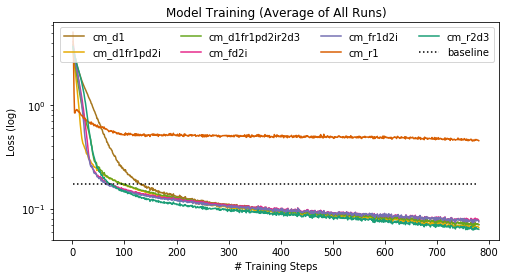

In [703]:
# plot mean results
plt.clf()
fig = plt.figure(figsize=(figwidth,0.5*figwidth))
for ind, row in mean_results.iterrows():
    plt.semilogy(list(range(1,782)), row["loss"], label=ind, color=color_map[row["name"]])
    
plt.semilogy(list(range(1,781)),[baseline_cm(120)]*780, ':', color="black",label="baseline")
plt.legend(ncol=4)
plt.ylabel("Loss (log)")
plt.xlabel("# Training Steps")
plt.title("Model Training (Average of All Runs)")
plt.show()

#### Smoothed Average with Shadows of All Runs

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


<Figure size 432x288 with 0 Axes>

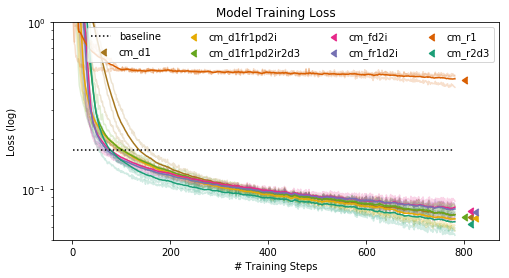

In [704]:
# plot all results (light) with average overlays (dark)
plt.clf()
fig = plt.figure(figsize=(figwidth,0.5*figwidth))

# plot all runs (very light)
for ind, row in all_results.iterrows():
    plt.semilogy(list(range(1,782)), row["loss"], 
                 color=color_map[row["name"]], alpha = 0.2)
    
# plot average of runs (dark)
for ind, row in mean_results.iterrows():
    plt.semilogy(list(range(1,782)), pd.rolling_mean(row["loss"], window), color=color_map[row["name"]])
    
plt.semilogy(list(range(1,781)),[baseline_cm(120)]*780, ':', color="black",label="baseline")

# add endpoints
i = 1
for ind, result in mean_results.iterrows():
    # todo: plot the rolling mean here
    plt.scatter(795 + 12*(i%3),result["mean_loss"], 
                color=color_map[ind], label=ind, s=pt_size, marker=4)
    i += 1

plt.legend(ncol=4)
plt.ylabel("Loss (log)")
plt.xlabel("# Training Steps")
# plt.xlim([0,800])
plt.ylim([0.5*1e-1, 1e0])
plt.title("Model Training Loss")

plt.savefig("figures/average_performance.png", dpi=300)

plt.show()

#### All Runs

<Figure size 432x288 with 0 Axes>

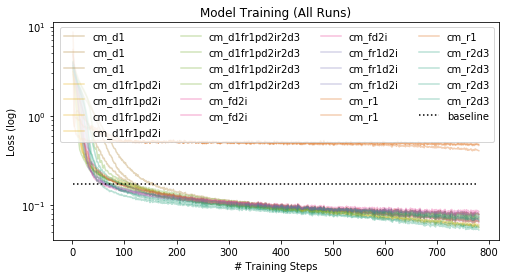

In [705]:
# plot all runs
plt.clf()
fig = plt.figure(figsize=(figwidth,0.5*figwidth))
for ind, row in all_results.iterrows():
    plt.semilogy(list(range(1,782)), row["loss"], 
                 label=row["name"], color=color_map[row["name"]], alpha=0.3)
    
plt.semilogy(list(range(1,781)),[baseline_cm(120)]*780, ':', color="black",label="baseline")
plt.legend(ncol=4)
plt.ylabel("Loss (log)")
plt.xlabel("# Training Steps")
plt.title("Model Training (All Runs)")
plt.show()

#### Cute Subplots

/Users/heidihurst/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:29: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


<Figure size 432x288 with 0 Axes>

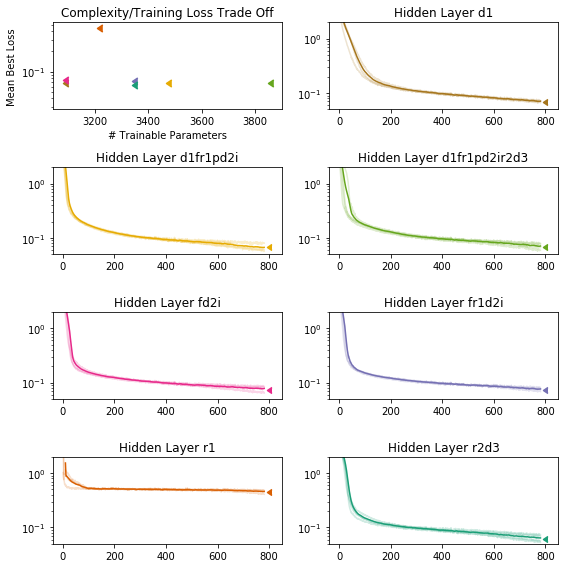

In [706]:
# plot subpanels of each one's performance/variation
plt.clf()
fig, axes = plt.subplots(4,2, sharex=True, sharey=True, figsize=(figwidth,figwidth))

networks = color_labels

plt.subplot(4,2,1)
for ind, result in mean_results.iterrows():
    plt.scatter(result["trainable_params"],result["mean_loss"], 
                color=color_map[ind], label=ind, s=pt_size, marker=4)
    plt.semilogy()

plt.title("Complexity/Training Loss Trade Off".format(problems[problem]))
plt.ylabel("Mean Best Loss")
plt.xlabel("# Trainable Parameters")


for i in range(len(networks)):
    # extract just the records we're interested in 
    interim_df = all_results[all_results["name"] == networks[i]]
    interim_mr = mean_results[mean_results["name"]==networks[i]]
    
    # plot in specific subplot
    plt.subplot(4,2,i+2)
    for ind, row in interim_df.iterrows():
        plt.semilogy(list(range(1,782)), row["loss"], label=row["name"], 
                     color=color_map[row["name"]], alpha=0.2)
        
    plt.semilogy(list(range(1,782)), pd.rolling_mean(interim_mr["loss"][0], window), 
                 "-", label="Hidden Layer {}".format(interim_mr["name"][3:]), 
                     color=color_map[row["name"]])
    
    plt.scatter(790, interim_mr["mean_loss"], color=color_map[row["name"]], marker=4)
        
    plt.title("Hidden Layer {}".format(networks[i][3:]))
    
    plt.ylim([0.5*1e-1, 2])
    
    
plt.tight_layout()

plt.savefig("figures/average_performance_subplots.png", dpi=300)

plt.show()

## SCRATCH